In [2]:
#%load_ext autoreload
%autoreload 2

In [1]:
 %reload_ext autoreload

In [3]:
#------NON-CONCEPTUAL------#
# begin by loading the different packages that we will be using


import anndata as ad
import numpy as np
import pandas as pd

import funcs as f

import matplotlib.pyplot as plt

from typing import Tuple,Union, List

from IPython.display import display
import warnings
warnings.filterwarnings("ignore")

In [4]:
# load data; we will begin with just one sample for the sake of convenience 
data_pths = dict(sample_1 = "../data/bc/curated/bc-A1.h5ad",
                 sample_2 = "../data/bc/curated/bc-A2.h5ad") 
data = {k:ad.read_h5ad(data_pths[k]) for k in data_pths.keys()}


In [5]:
display(data)

{'sample_1': AnnData object with n_obs × n_vars = 3813 × 33514
     obs: 'barcodes', 'under_tissue', '_x', '_y', 'x', 'y'
     var: 'name', 'id', 'n_counts'
     uns: 'fiducial_diameter_fullres', 'image_hires', 'spot_diameter_fullres', 'tissue_hires_scalef',
 'sample_2': AnnData object with n_obs × n_vars = 4015 × 33514
     obs: 'barcodes', 'under_tissue', '_x', '_y', 'x', 'y'
     var: 'name', 'id', 'n_counts'
     uns: 'fiducial_diameter_fullres', 'image_hires', 'spot_diameter_fullres', 'tissue_hires_scalef'}

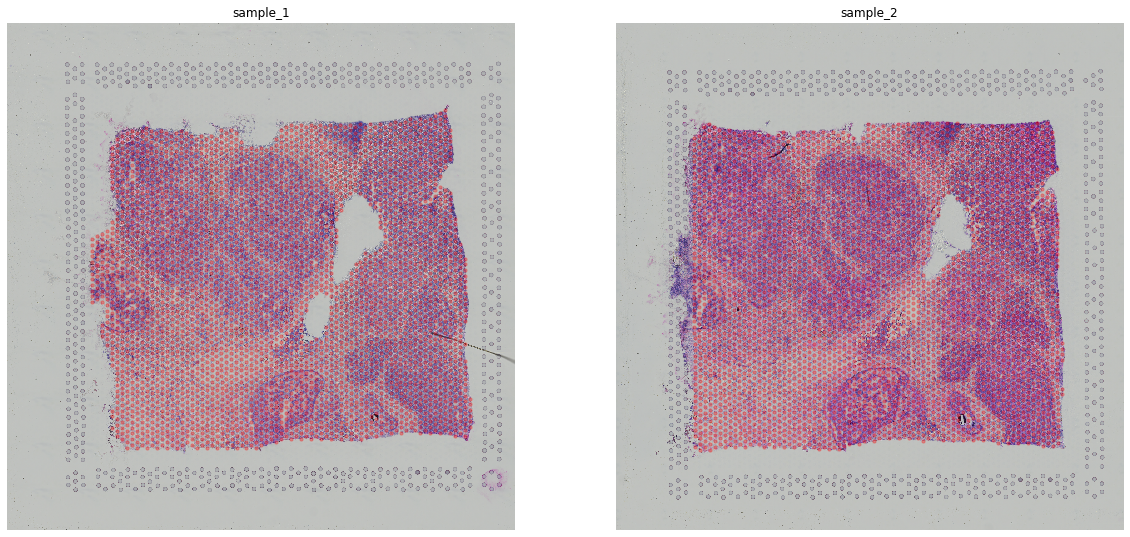

In [6]:
fig,ax = plt.subplots(1,2, figsize = (20,10))
plt_args = {"s":10, "c":"red","alpha":0.3}

for ii,(k,v) in enumerate(data.items()):
    f.plot_data(ax[ii],
                v,
                title = k,
                show_image=True,
                plt_args = plt_args,
               )
plt.show()

In [7]:
#n_data,n_meta = f.join_data(data)
data = f.join_data(data)

In [8]:
display(data)

AnnData object with n_obs × n_vars = 7828 × 33514
    obs: 'barcodes', 'under_tissue', '_x', '_y', 'x', 'y', 'sample'
    var: 'name', 'id', 'n_counts-0', 'n_counts-1'
    uns: 0, 1

In [9]:
from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import KMeans as km
from sklearn.decomposition import PCA
import umap

# set a random seed for reproducibility
np.random.seed(1337)

# normalize the expression data
y = f.naive_normalize(data.X)
# specify number of principal components to use in PCA, feel free to change!
pca_components = 20
# run PCA
y = PCA(n_components = pca_components).fit_transform(y)
# run UMAP
y = umap.UMAP(n_components = 2).fit_transform(y)
# specify the number of components in the GMM, feel free to change!
gmm_components  = 7
# fit GMM to the data
fitted_gmm = GMM(n_components = gmm_components).fit(y)
# get component weights for each spot, "soft labels"
labels_soft = fitted_gmm.predict_proba(y)
# get hard labels for each spot
labels_hard = np.argmax(labels_soft,
                        axis = 1)

Text(0.5, 1.0, 'UMAP-space | Color by Sample')

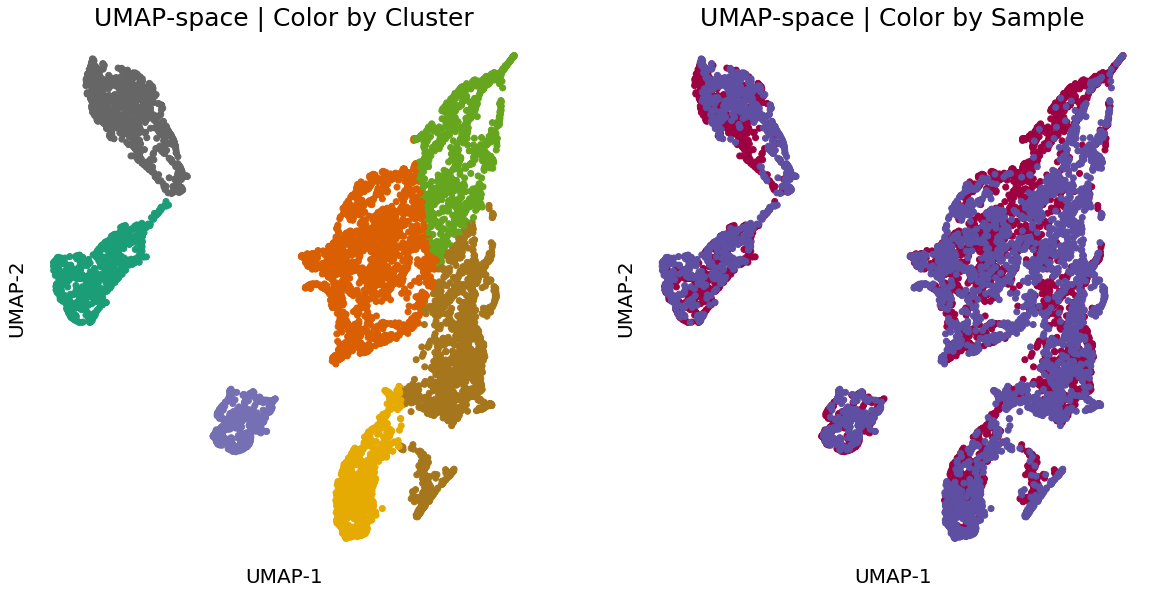

In [10]:
fig,ax = plt.subplots(nrows = 1,
                      ncols = 2,
                      figsize = (20,10))

# plot embedded data, color by hard labels
sc = ax[0].scatter(y[:,0],
           y[:,1],
           c = labels_hard,
           cmap = plt.cm.Dark2,
          )

sc = ax[1].scatter(y[:,0],
           y[:,1],
           c = data.obs["sample"]\
                   .values\
                   .astype(int),
           cmap = plt.cm.Spectral,
          )


for aa in ax:

    aa.set_aspect("equal")

    aa.set_xlabel("UMAP-1",
                     fontsize = 20)
    aa.set_ylabel("UMAP-2",
                     fontsize = 20)

    f.clean_ax(aa)

    
ax[0].set_title("UMAP-space | Color by Cluster",
                fontsize = 25)
ax[1].set_title("UMAP-space | Color by Sample",
                fontsize = 25)



In [11]:
def get_indices(data : ad.AnnData,
                label : int,
                category : str = "sample",
               )-> np.ndarray:
        
        idx = np.where(data.obs["sample"] == label)[0]
        return idx

In [12]:
data

AnnData object with n_obs × n_vars = 7828 × 33514
    obs: 'barcodes', 'under_tissue', '_x', '_y', 'x', 'y', 'sample'
    var: 'name', 'id', 'n_counts-0', 'n_counts-1'
    uns: 0, 1

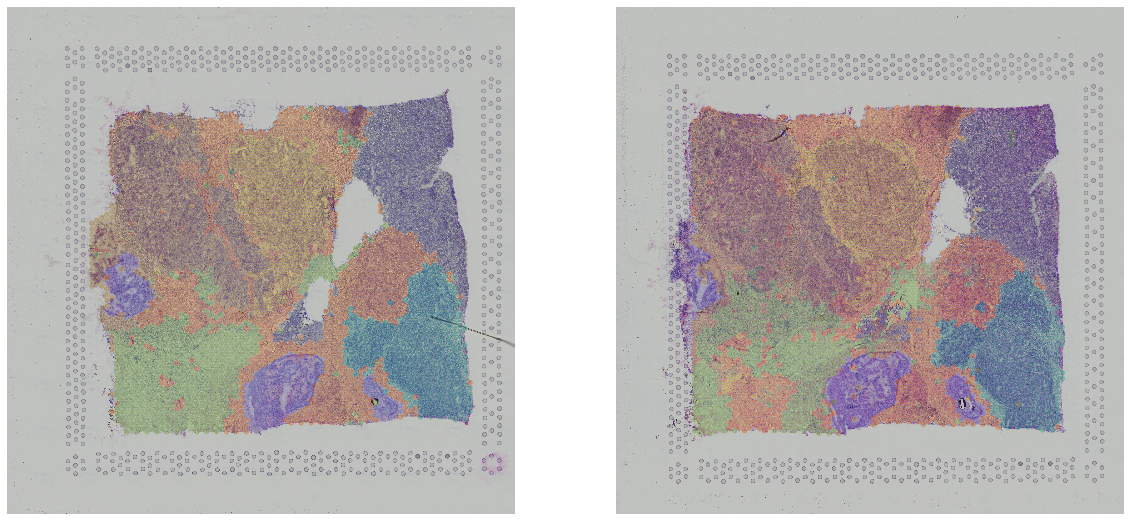

In [13]:
fig,ax = plt.subplots(nrows = 1,
                      ncols = 2,
                      figsize = (20,
                                 10))

for k,sample in enumerate(np.unique(data.obs["sample"])):
    idx = get_indices(data,sample)
    f.plot_data(ax[k],
                data[idx],
                plt_args = {"c":labels_hard[idx],
                            "cmap":plt.cm.Dark2,
                            "alpha":0.3,
                           },
                show_image = True,
                index = int(sample),
               )